In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torchvision
import torch
import time
import numpy as np
import torch.nn.functional as F

from torch import nn, optim
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

from cvae import cVAE_MNIST as cVAE

In [ ]:
DEVICE = (f'cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# Download MNIST to test
train_dataset = torchvision.datasets.MNIST(
    root='./mnist_data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [6]:
def loss_function(x, x_hat, mu, logvar):
    bce_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return bce_loss + kld_loss

def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets

In [7]:
def train_model(model, optimizer, dataset, loss_fn, epochs, batch_size, save_freq=None, save_path=None, scheduler=None, device='cpu'):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model.train()
    
    print(f'Learning rate: {optimizer.param_groups[0]["lr"]}')
    print(f'Scheduler: {scheduler}' if scheduler else 'No learning rate scheduling!')
    print(f'Training for {epochs} epochs, with batch size={batch_size}')
    print(f'Using device: {device}')
    print(f'Saving model every {save_freq} epochs to {save_path}' if save_freq else 'WARNING: Will not save model!')

    for e in range(epochs):
        losses = []
        all_pred, all_true = [], []
        t = time.time()
        print(f'\n-----Epoch {e+1}/{epochs}-----')
        for i, (x, labels) in enumerate(loader):
            labels = one_hot(labels, 10).to(device)
            x = x.to(device).squeeze().flatten(start_dim=1)
            pred, mu, logvar = model(x, labels)
            loss = loss_fn(x, pred, mu, logvar)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            losses.append(loss.item())
            all_pred.append(pred.cpu())
            all_true.append(labels.cpu())

            if len(losses) == 500 or i == len(loader)-1:
                elapsed = time.time() - t
                t = time.time()
                print(f'Batch {i+1}/{len(loader)}, loss: {np.mean(losses)} ({elapsed:.3f}s)')
                losses = []
                
        if scheduler is not None:
            scheduler.step()
            
        if save_freq and ((e+1) % save_freq == 0 or e == epochs-1):
            save_model(save_path, model, optimizer, epochs)
            print(f'Saved to {save_path}')       
         
#         f1 = f1_score(torch.cat(all_true, dim=0), 
#                       (torch.sigmoid(torch.cat(all_pred, dim=0)) > 0.5).type(torch.float), 
#                       average='weighted')
#         print(f'F1 score: {f1}')

In [8]:
batch_size = 32
lr = 1e-3
model = cVAE(28*28, 28, 10).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 50

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_model(model, optimizer, train_dataset, loss_function, epochs=epochs, batch_size=batch_size, device=DEVICE,
           save_path='mnist_cvae.pth')

Learning rate: 0.001
No learning rate scheduling!
Training for 50 epochs, with batch size=32
Using device: cuda:0

-----Epoch 1/50-----
Batch 500/1875, loss: 5493.633556152344 (1.658s)
Batch 1000/1875, loss: 4133.3587109375 (1.480s)
Batch 1500/1875, loss: 3829.6622939453123 (1.475s)
Batch 1875/1875, loss: 3695.554291015625 (1.101s)

-----Epoch 2/50-----
Batch 500/1875, loss: 3599.687220703125 (1.414s)
Batch 1000/1875, loss: 3552.3040932617187 (1.419s)
Batch 1500/1875, loss: 3506.4351083984375 (1.420s)
Batch 1875/1875, loss: 3485.76364453125 (1.064s)

-----Epoch 3/50-----
Batch 500/1875, loss: 3455.286973144531 (1.417s)
Batch 1000/1875, loss: 3416.9113315429686 (1.413s)
Batch 1500/1875, loss: 3405.2348891601564 (1.409s)
Batch 1875/1875, loss: 3397.400619140625 (1.057s)

-----Epoch 4/50-----
Batch 500/1875, loss: 3372.5529375 (1.409s)
Batch 1000/1875, loss: 3373.7091953125 (1.418s)
Batch 1500/1875, loss: 3344.754427734375 (1.418s)
Batch 1875/1875, loss: 3353.6075989583333 (1.062s)

-----

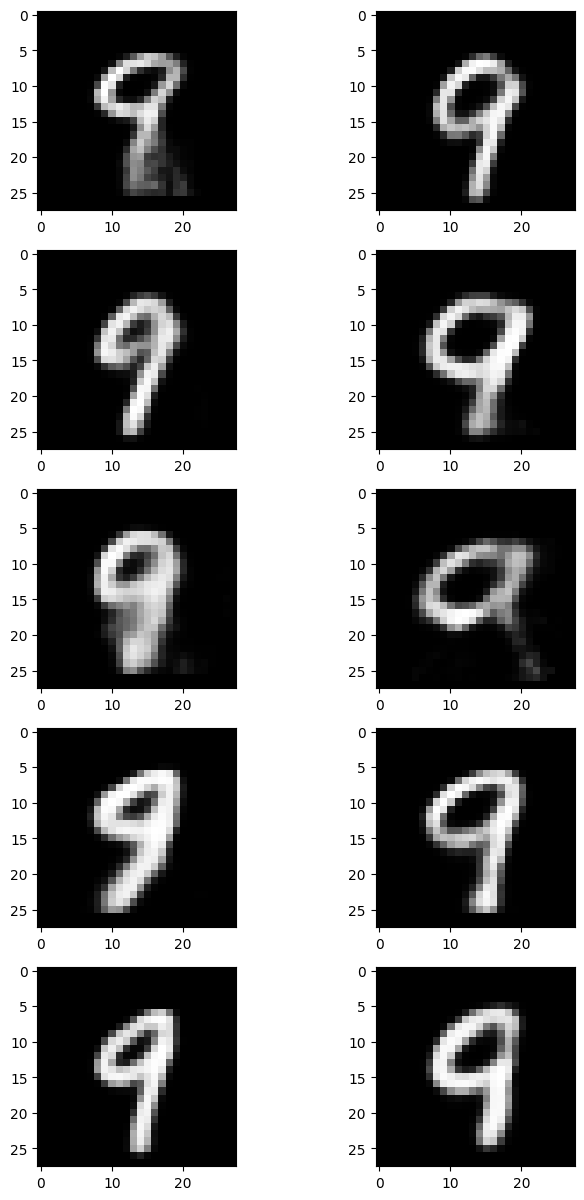

In [29]:
with torch.no_grad():
#     c = torch.eye(10, 10).cuda()
    c = torch.zeros(10, 10).to(DEVICE)
    c[:,9] = 1
    sample = torch.randn(10, 28).to(DEVICE) * 0.75
    sample = model.decode(sample, c).cpu()
    
    fig, ax = plt.subplots(5, 2, figsize=(8,15))
    
    for i in range(10):
        ax[i//2, i%2].imshow(sample[i].flatten().reshape(28,28), cmap='gray')

In [40]:
train_dataset.train_labels.shape

torch.Size([60000])